In [ ]:
# Train Random Forest and XGBoost models and compare their predictions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from datetime import datetime, timedelta
# Load the data
df = pd.read_csv('gold_price_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2290 non-null   datetime64[ns]
 1   SPX      2290 non-null   float64       
 2   GLD      2290 non-null   float64       
 3   USO      2290 non-null   float64       
 4   SLV      2290 non-null   float64       
 5   EUR/USD  2290 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 107.5 KB


In [ ]:
# Missing Values/Null Values Count
df.isna().sum().sort_values(ascending=False)

,0
Date,0
SPX,0
GLD,0
USO,0
SLV,0
EUR/USD,0


In [ ]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [ ]:
# Display the first few rows
print("Original data sample:")
print(df.head())

Original data sample:
        Date          SPX        GLD        USO     SLV   EUR/USD
0 2008-01-02  1447.160034  84.860001  78.470001  15.180  1.471692
1 2008-01-03  1447.160034  85.570000  78.370003  15.285  1.474491
2 2008-01-04  1411.630005  85.129997  77.309998  15.167  1.475492
3 2008-01-07  1416.180054  84.769997  75.500000  15.053  1.468299
4 2008-01-08  1390.189941  86.779999  76.059998  15.590  1.557099


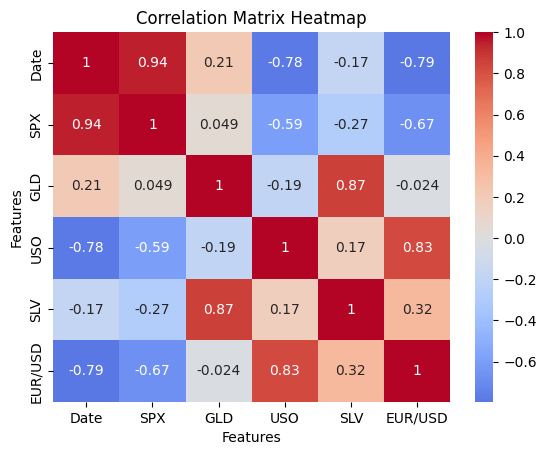

In [ ]:
correlation  = df.corr()
sns.heatmap(correlation, cmap='coolwarm',
            center=0, annot=True)
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

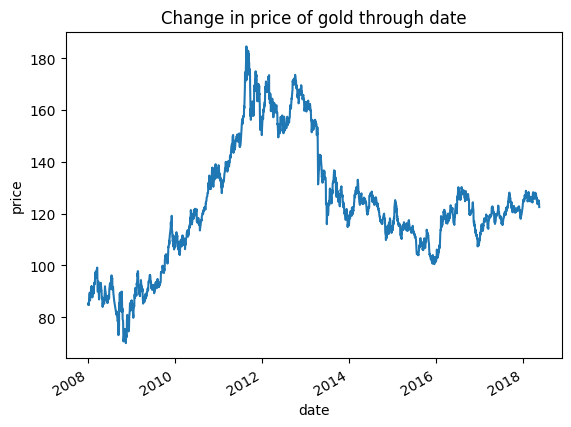

In [ ]:
fig, ax = plt.subplots()
ax.plot(df['Date'], df['GLD'])
plt.title("Change in price of gold through date")
plt.xlabel("date")
plt.ylabel("price")
fig.autofmt_xdate()
plt.show()

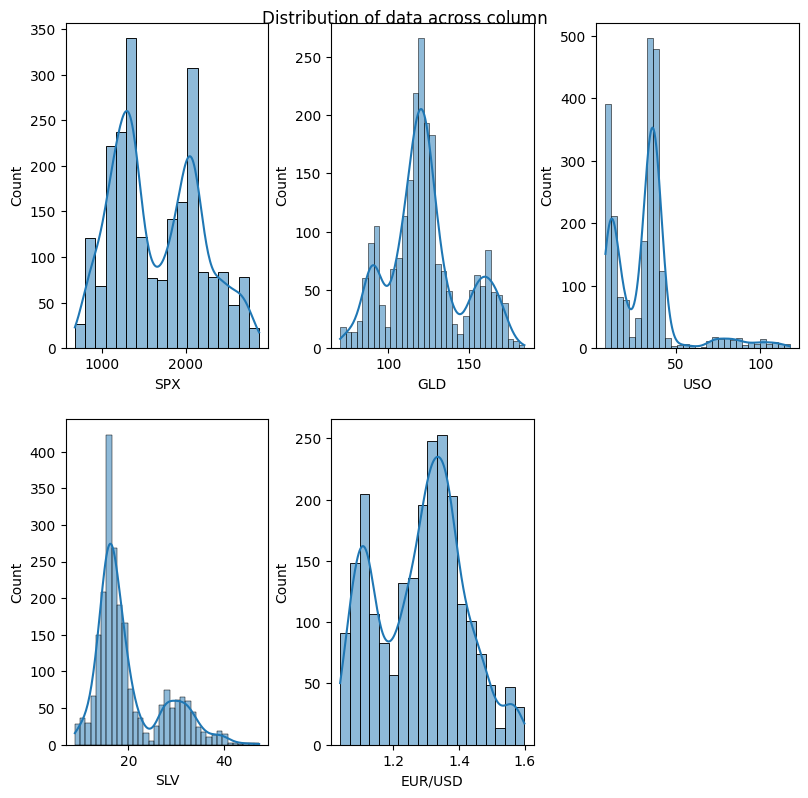

In [ ]:
fig = plt.figure(figsize=(8, 8))
fig.suptitle('Distribution of data across column')
temp = df.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=item, kde=True)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

In [ ]:
# Import necessary libraries (if not already done)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Feature Engineering
# 1. Create lag features for GLD (previous days' prices)
for i in range(1, 6):
    df[f'GLD_lag_{i}'] = df['GLD'].shift(i)

# 2. Create rolling statistics
df['GLD_rolling_mean_7'] = df['GLD'].rolling(window=7).mean()
df['GLD_rolling_std_7'] = df['GLD'].rolling(window=7).std()

# 3. Create price momentum features
df['GLD_momentum_1'] = df['GLD'] - df['GLD'].shift(1)
df['GLD_momentum_5'] = df['GLD'] - df['GLD'].shift(5)

# 4. Create day of week, month, year features
df['day_of_week'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

# 5. Create features from other columns (SPX, USO, SLV, EUR/USD)
for col in ['SPX', 'USO', 'SLV', 'EUR/USD']:
    df[f'{col}_lag_1'] = df[col].shift(1)
    df[f'{col}_momentum_1'] = df[col] - df[col].shift(1)

# Drop rows with NaN values
df_clean = df.dropna()

# Prepare data for modeling
df_clean['target'] = df_clean['GLD'].shift(-1)
df_model = df_clean.dropna()

# Features and target
X = df_model.drop(['Date', 'GLD', 'target'], axis=1)
y = df_model['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False)

# Get test set dates
test_dates = df_model.iloc[-len(X_test):]['Date'].reset_index(drop=True)

print("Training Random Forest model...")
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Metrics for Random Forest
rf_rmse = mean_squared_error(y_test, rf_predictions) ** 0.5
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("Training XGBoost model...")
# Train XGBoost with tuning and early stopping
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=20  # Add early_stopping_rounds here
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    # early_stopping_rounds=20,  Remove from here
    verbose=False
)

xgb_predictions = xgb_model.predict(X_test)

# Metrics for XGBoost
xgb_rmse = mean_squared_error(y_test, xgb_predictions) ** 0.5
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

# Create results DataFrame
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual_GLD': y_test.values,
    'RF_Predicted': rf_predictions,
    'XGB_Predicted': xgb_predictions
})

# Errors
results_df['RF_Error'] = results_df['Actual_GLD'] - results_df['RF_Predicted']
results_df['XGB_Error'] = results_df['Actual_GLD'] - results_df['XGB_Predicted']

# Display performance
print("\nModel Performance Metrics:")
print(f"Random Forest - RMSE: {rf_rmse:.4f}, MAE: {rf_mae:.4f}, R²: {rf_r2:.4f}")
print(f"XGBoost - RMSE: {xgb_rmse:.4f}, MAE: {xgb_mae:.4f}, R²: {xgb_r2:.4f}")

# Sample predictions
print("\nSample of predictions (first 10 rows):")
print(results_df.head(10))


<ipython-input-8-656cb3a48fac>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['target'] = df_clean['GLD'].shift(-1)


Training Random Forest model...
Training XGBoost model...

Model Performance Metrics:
Random Forest - RMSE: 1.4447, MAE: 1.1429, R²: 0.9110
XGBoost - RMSE: 1.3616, MAE: 1.0600, R²: 0.9209

Sample of predictions (first 10 rows):
        Date  Actual_GLD  RF_Predicted  XGB_Predicted  RF_Error  XGB_Error
0 2016-04-14  117.739998    117.377300     117.957130  0.362698  -0.217132
1 2016-04-18  119.580002    116.893701     117.402184  2.686301   2.177818
2 2016-04-19  118.970001    118.127601     119.076958  0.842400  -0.106957
3 2016-04-20  119.419998    118.392300     118.593468  1.027698   0.826530
4 2016-04-21  118.230003    118.223701     118.563278  0.006302  -0.333275
5 2016-04-25  118.699997    117.787700     118.201454  0.912297   0.498543
6 2016-04-26  119.040001    118.220400     118.725143  0.819601   0.314858
7 2016-04-27  121.290001    117.796401     118.132446  3.493600   3.157555
8 2016-04-28  123.239998    119.834500     120.043358  3.405498   3.196640
9 2016-05-02  122.9599

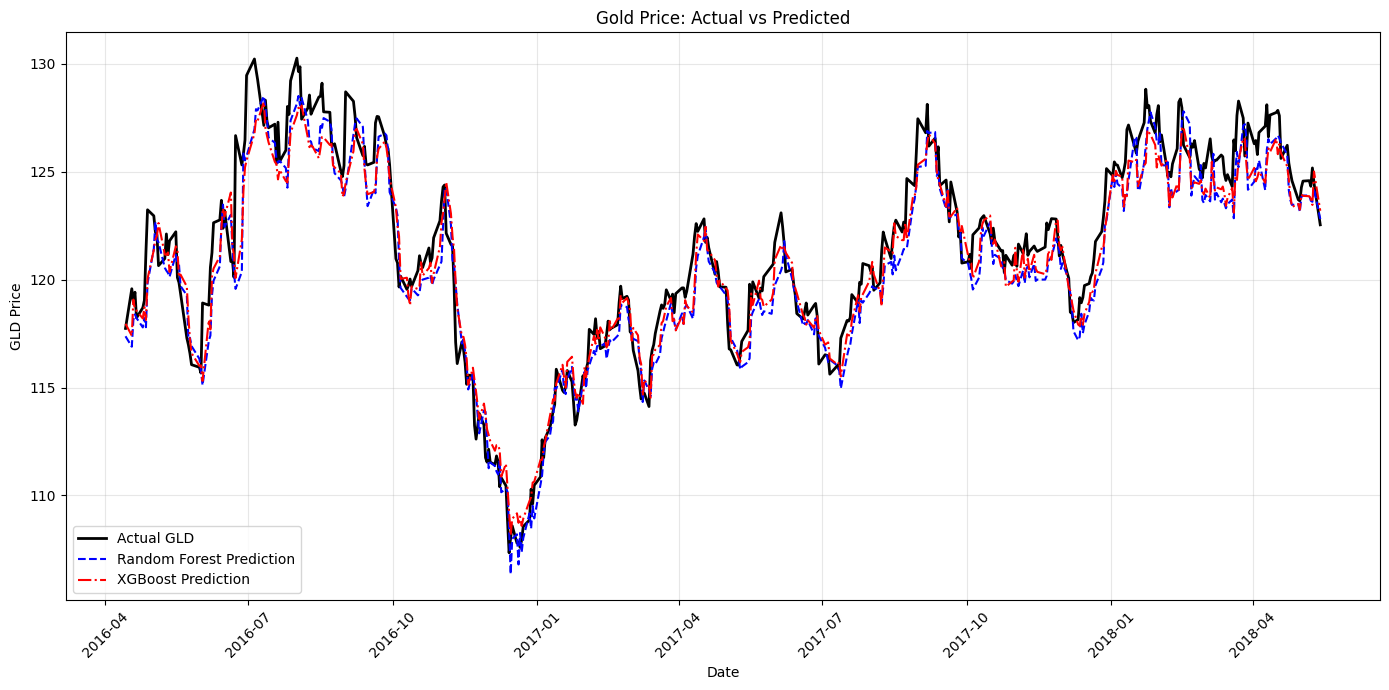

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(results_df['Date'], results_df['Actual_GLD'], label='Actual GLD', color='black', linewidth=2)
plt.plot(results_df['Date'], results_df['RF_Predicted'], label='Random Forest Prediction', color='blue', linestyle='--')
plt.plot(results_df['Date'], results_df['XGB_Predicted'], label='XGBoost Prediction', color='red', linestyle='-.')
plt.title('Gold Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('GLD Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

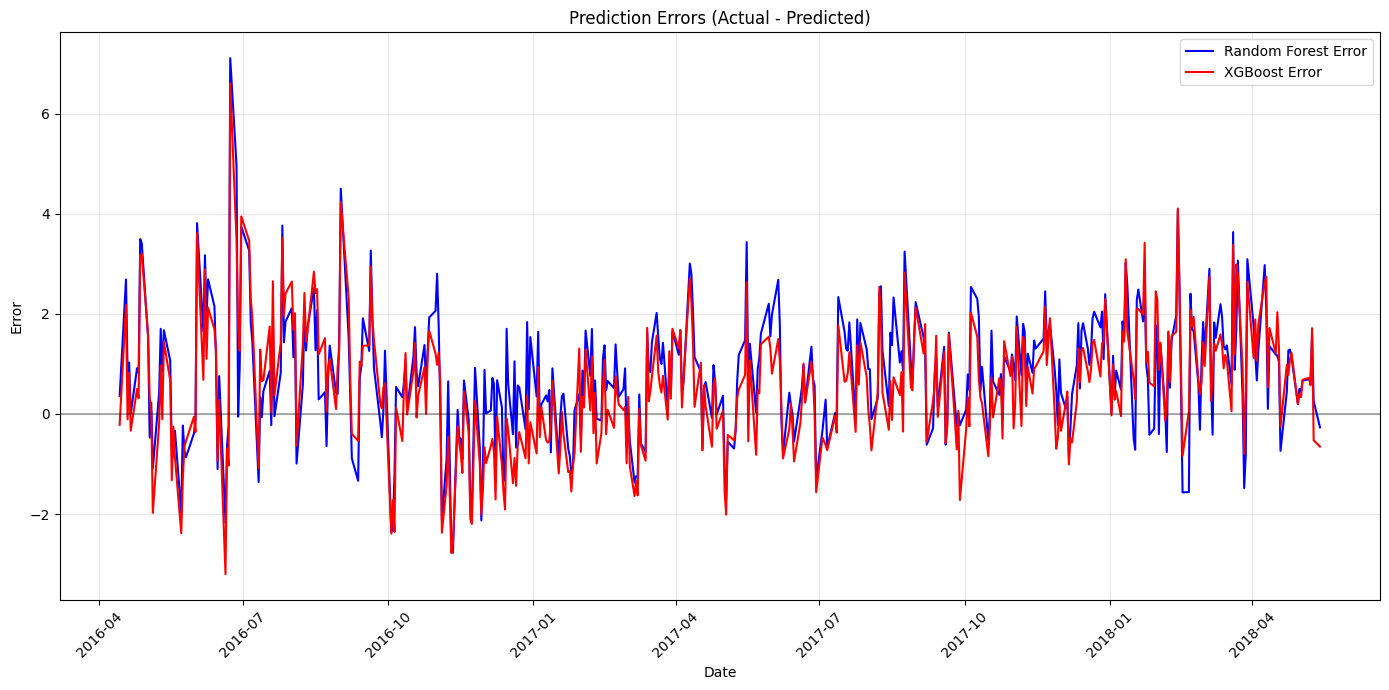

In [ ]:
# Plot prediction errors
plt.figure(figsize=(14, 7))
plt.plot(results_df['Date'], results_df['RF_Error'], label='Random Forest Error', color='blue')
plt.plot(results_df['Date'], results_df['XGB_Error'], label='XGBoost Error', color='red')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Prediction Errors (Actual - Predicted)')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

# Choose a threshold (e.g., median gold price)
threshold = y_test.median()

# Categorize predictions
rf_predictions_binary = (rf_predictions >= threshold).astype(int)
xgb_predictions_binary = (xgb_predictions >= threshold).astype(int)
y_test_binary = (y_test >= threshold).astype(int)

# Calculate classification metrics
rf_accuracy = accuracy_score(y_test_binary, rf_predictions_binary)
rf_precision = precision_score(y_test_binary, rf_predictions_binary)
rf_recall = recall_score(y_test_binary, rf_predictions_binary)
rf_f1 = f1_score(y_test_binary, rf_predictions_binary)

xgb_accuracy = accuracy_score(y_test_binary, xgb_predictions_binary)
xgb_precision = precision_score(y_test_binary, xgb_predictions_binary)
xgb_recall = recall_score(y_test_binary, xgb_predictions_binary)
xgb_f1 = f1_score(y_test_binary, xgb_predictions_binary)

# Create table data
table_data = [
    ["Metric", "Random Forest", "XGBoost"],
    ["Accuracy", rf_accuracy, xgb_accuracy],
    ["Precision", rf_precision, xgb_precision],
    ["Recall", rf_recall, xgb_recall],
    ["F1-score", rf_f1, xgb_f1]
]

# Display table
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))

╒═══════════╤═════════════════╤═══════════╕
│ Metric    │   Random Forest │   XGBoost │
╞═══════════╪═════════════════╪═══════════╡
│ Accuracy  │        0.87965  │  0.908096 │
├───────────┼─────────────────┼───────────┤
│ Precision │        0.968085 │  0.939535 │
├───────────┼─────────────────┼───────────┤
│ Recall    │        0.787879 │  0.874459 │
├───────────┼─────────────────┼───────────┤
│ F1-score  │        0.868735 │  0.90583  │
╘═══════════╧═════════════════╧═══════════╛


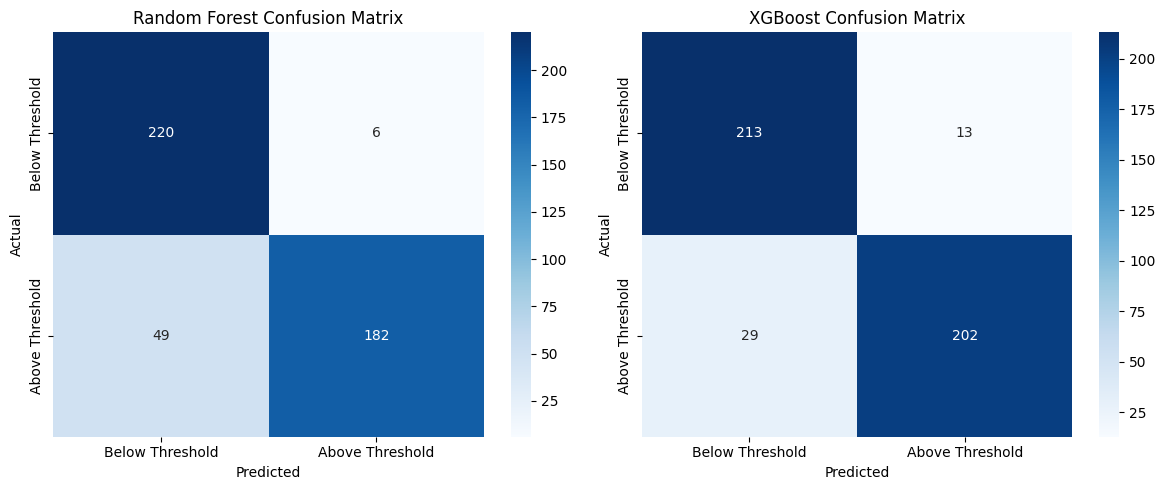

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrices
rf_cm = confusion_matrix(y_test_binary, rf_predictions_binary)
xgb_cm = confusion_matrix(y_test_binary, xgb_predictions_binary)

# Plot confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Below Threshold', 'Above Threshold'],
            yticklabels=['Below Threshold', 'Above Threshold'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(xgb_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Below Threshold', 'Above Threshold'],
            yticklabels=['Below Threshold', 'Above Threshold'])
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


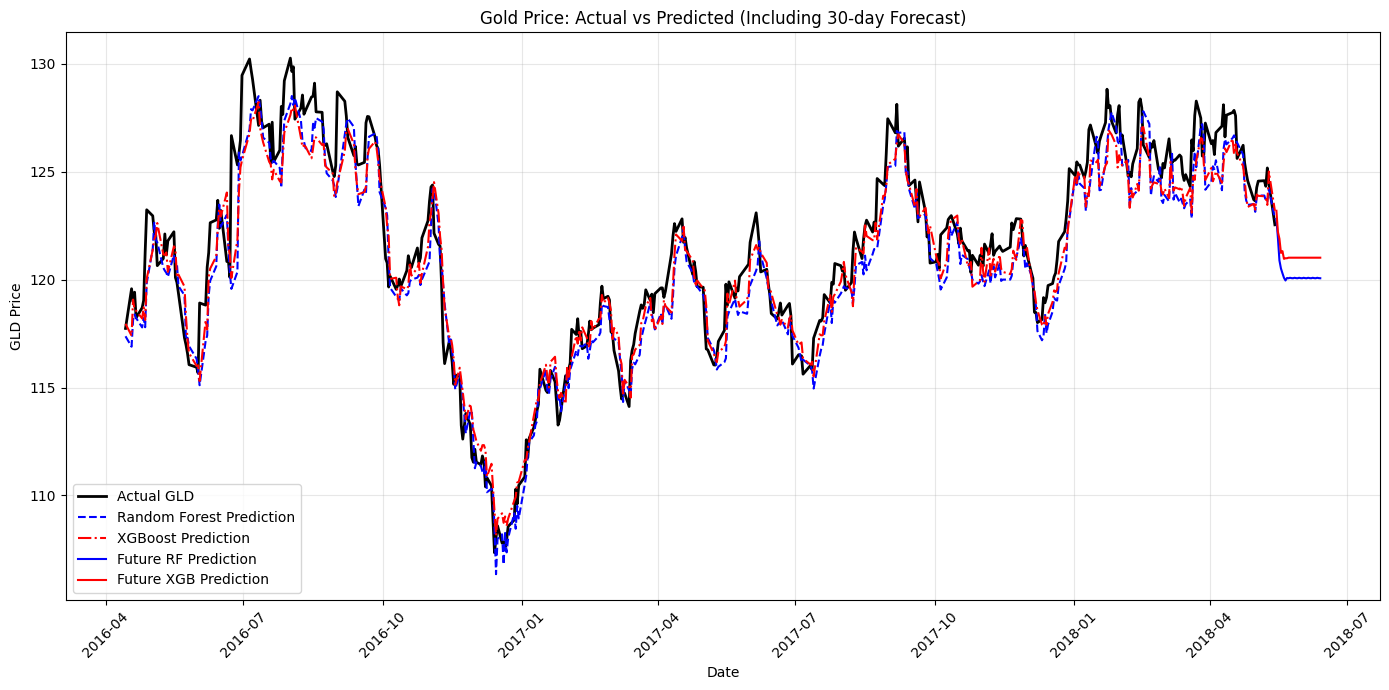

In [ ]:
# prompt: future 30 days predicted graph

# Assuming 'results_df' and your models are already defined as in the previous code

# Predict the next 30 days
last_date = df_model['Date'].iloc[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, 31)]

last_data_point = X.iloc[-1].copy()  # Get the last data point for features and make a copy

# Initialize GLD for the first prediction (use the actual last GLD value)
last_gld = df_model['GLD'].iloc[-1]

future_predictions_rf = []
future_predictions_xgb = []

for _ in range(30):
    # Predict the next day
    rf_pred = rf_model.predict(last_data_point.to_frame().T)
    future_predictions_rf.append(rf_pred[0])

    xgb_pred = xgb_model.predict(last_data_point.to_frame().T)
    future_predictions_xgb.append(xgb_pred[0])

    # Update the features for the next prediction
    last_data_point['GLD_lag_1'] = rf_pred[0]
    last_data_point['GLD_momentum_1'] = rf_pred[0] - last_gld  # Use last_gld instead of last_data_point['GLD']

    # Update last_gld for the next iteration
    last_gld = rf_pred[0]
    # ... Update other lag and momentum features using last_gld or rf_pred[0]
  #Update other features...


# Create a DataFrame for the future predictions
future_df = pd.DataFrame({
    'Date': future_dates,
    'RF_Predicted': future_predictions_rf,
    'XGB_Predicted': future_predictions_xgb
})


# Plot the future predictions
plt.figure(figsize=(14, 7))
plt.plot(results_df['Date'], results_df['Actual_GLD'], label='Actual GLD', color='black', linewidth=2)
plt.plot(results_df['Date'], results_df['RF_Predicted'], label='Random Forest Prediction', color='blue', linestyle='--')
plt.plot(results_df['Date'], results_df['XGB_Predicted'], label='XGBoost Prediction', color='red', linestyle='-.')
plt.plot(future_df['Date'], future_df['RF_Predicted'], label='Future RF Prediction', color='blue')
plt.plot(future_df['Date'], future_df['XGB_Predicted'], label='Future XGB Prediction', color='red')
plt.title('Gold Price: Actual vs Predicted (Including 30-day Forecast)')
plt.xlabel('Date')
plt.ylabel('GLD Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
